In [7]:
# Import Required Libraries
import cudaq
import numpy as np
import time
import sys
from cudaq import spin
import matplotlib.pyplot as plt
from typing import List
from plot_config import *

In [8]:
@cudaq.kernel
def get_initial_state(n_spins: int):
    """Create initial state |1010...>"""
    qubits = cudaq.qvector(n_spins)
    for i in range(0, n_spins, 2):
        x(qubits[i])

In [9]:
@cudaq.kernel
def trotter_step(state: cudaq.State, dt: float, Jx: float, Jy: float, Jz: float,
                 h_x: list[float], h_y: list[float], h_z: list[float], _use_XXYYZZ_gate: bool,
                 coefficients: List[complex], words: List[cudaq.pauli_word]):
    """Perform single Trotter step"""
    qubits = cudaq.qvector(state)
    n_spins = len(qubits)

    # Apply two-qubit interaction terms
    if _use_XXYYZZ_gate:
        for j in range(2):
            for i in range(j % 2, n_spins - 1, 2):
                rx(-np.pi/2,qubits[i])
                rx(np.pi/2,qubits[i+1])
                x.ctrl(qubits[i], qubits[i+1])
                h(qubits[i])
                s(qubits[i])
                rz(-2*Jy*dt,qubits[i+1])
                x.ctrl(qubits[i], qubits[i+1])
                h(qubits[i])
                rx(2*Jx*dt,qubits[i])
                rz(-2*Jz*dt,qubits[i+1])
                x.ctrl(qubits[i], qubits[i+1])
    else:
        for i in range(len(coefficients)):
            exp_pauli(coefficients[i].real * dt, qubits, words[i])

In [11]:
def create_hamiltonian_heisenberg(n_spins: int, Jx: float, Jy: float, Jz: float, h_x: list[float], h_y: list[float], h_z: list[float]):
    """Create the Hamiltonian operator"""
    ham = 0

    # Add two-qubit interaction terms for Heisenberg Hamiltonian
    for i in range(0, n_spins - 1):
        ham += Jx * spin.x(i) * spin.x(i + 1)
        ham += Jy * spin.y(i) * spin.y(i + 1)
        ham += Jz * spin.z(i) * spin.z(i + 1)

    return ham

In [12]:
def create_hamiltonian_qimf(n_spins: int, J: float, h_x: float, h_y: float):
    ham = 0
    for i in range(n_spins - 1):
        ham += J * spin.x(i) * spin.x(i + 1)
        
    for i in range(n_spins):
        ham += h_x * spin.x(i) + h_y * spin.y(i)
    return ham

In [13]:
def extractCoefficients(hamiltonian: cudaq.SpinOperator):
    result = []
    for term in hamiltonian:
        result.append(term.get_coefficient())
    return result

def extractWords(hamiltonian: cudaq.SpinOperator):
    # Our kernel uses these words to apply exp_pauli to the entire state.
    # we hence ensure that each pauli word covers the entire space.
    n_spins = hamiltonian.qubit_count
    result = []
    for term in hamiltonian:
        result.append(term.get_pauli_word(n_spins))
    return result

In [ ]:
def partial_trace_density_matrix(psi: np.ndarray, subsystem: List[int], n_qubits: int) -> np.ndarray:
    psi = psi / np.linalg.norm(psi)
    rho = np.outer(psi, np.conj(psi))  # shape: (2^n, 2^n)

    traced_out = [i for i in range(n_qubits) if i not in subsystem]
    dim_A = 2 ** len(subsystem)
    dim_B = 2 ** len(traced_out)

    rho = rho.reshape([2]*2*n_qubits)
    perm = subsystem + traced_out + [i + n_qubits for i in subsystem + traced_out]
    rho = rho.transpose(perm)

    rho = rho.reshape([dim_A, dim_B, dim_A, dim_B])
    rho_A = np.einsum('ijik->jk', rho) 

    return rho_A

In [15]:
import cupy as cp
from typing import List

def partial_trace_schmidt_cupy(psi: cp.ndarray, keep: List[int], n_qubits: int) -> cp.ndarray:
    psi = psi / cp.linalg.norm(psi)

    traced_out = [i for i in range(n_qubits) if i not in keep]
    dim_keep = 2 ** len(keep)
    dim_traced = 2 ** len(traced_out)
    psi = psi.reshape([2] * n_qubits)
    perm = keep + traced_out
    psi = psi.transpose(perm)
    psi = psi.reshape(dim_keep, dim_traced)

    rho_A = psi @ psi.conj().T
    return rho_A


In [16]:
def entropy(rho):
    eigvals = np.linalg.eigvalsh(rho)
    eigvals = eigvals[eigvals > 0]  
    return -np.sum(eigvals * np.log2(eigvals))

In [17]:
def purity(rho):
    return cp.real(cp.trace(rho @ rho)).item()

In [57]:
def simulation_typical (n_spins: int, cal: str, sub: int, initial_state, r=100, h_x_val=0.8090, h_y_val=0.9045, J_val=1.0): 
    n = n_spins
    state = initial_state
    out_list = []
    time_list = []

    dt = 0.1
    subsystem = list(range(sub)) 

    h_x = np.full(n_spins, h_x_val) 
    h_y = np.full(n_spins, h_y_val) 
    h_z = np.zeros(n_spins)

    hamiltonian = create_hamiltonian_qimf(n_spins, J=J_val, h_x=h_x_val, h_y=h_y_val)
    
    coefficients = extractCoefficients(hamiltonian)
    words = extractWords(hamiltonian)
    Jy = 0 
    Jz = 0
    Jx = 1.0
    _use_XXYYZZ_gate = False
    print(hamiltonian) 
    print(coefficients) 
    
    start_time = time.time()
    for step in range(1, r + 1):
        state = cudaq.get_state(trotter_step, state, dt, Jx, Jy, Jz, h_x, h_y, h_z,
                                _use_XXYYZZ_gate, coefficients, words)
        psi = cp.array(state)
        rho_A = partial_trace_schmidt_cupy(psi, subsystem, n_qubits=n_spins)
        if cal == 'purity':
            S = purity(rho_A)
        elif cal == 'entropy':
            S = entropy(rho_A)
        else:
            print('invalid input') 
            return 1 
            
        out_list.append(S)
        time_list.append(dt * step)
    
    total_time = time.time() - start_time
    print(f"Simulation done in {total_time:.2f} seconds")
    out_np = np.array([x.get() if hasattr(x, 'get') else x for x in out_list])
    return out_np, subsystem

/tmp/ipykernel_1563310/1119622745.py:4: DeprecationWarning: use `evaluate_coefficient` instead
  result.append(term.get_coefficient())


(0+0i) + (1+0i) * X0X1 + (1+0i) * X1X2 + (1+0i) * X2X3 + (1+0i) * X3X4 + (1+0i) * X4X5 + (1+0i) * X5X6 + (1+0i) * X6X7 + (1+0i) * X7X8 + (1+0i) * X8X9 + (1+0i) * X9X10 + (1+0i) * X10X11 + (0.809+0i) * X0 + (0.9045+0i) * Y0 + (0.809+0i) * X1 + (0.9045+0i) * Y1 + (0.809+0i) * X2 + (0.9045+0i) * Y2 + (0.809+0i) * X3 + (0.9045+0i) * Y3 + (0.809+0i) * X4 + (0.9045+0i) * Y4 + (0.809+0i) * X5 + (0.9045+0i) * Y5 + (0.809+0i) * X6 + (0.9045+0i) * Y6 + (0.809+0i) * X7 + (0.9045+0i) * Y7 + (0.809+0i) * X8 + (0.9045+0i) * Y8 + (0.809+0i) * X9 + (0.9045+0i) * Y9 + (0.809+0i) * X10 + (0.9045+0i) * Y10 + (0.809+0i) * X11 + (0.9045+0i) * Y11
[0j, (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (0.809+0j), (0.9045+0j), (0.809+0j), (0.9045+0j), (0.809+0j), (0.9045+0j), (0.809+0j), (0.9045+0j), (0.809+0j), (0.9045+0j), (0.809+0j), (0.9045+0j), (0.809+0j), (0.9045+0j), (0.809+0j), (0.9045+0j), (0.809+0j), (0.9045+0j), (0.809+0j), (0.9045+0j), (0.809+0j), (0.9045+0j)

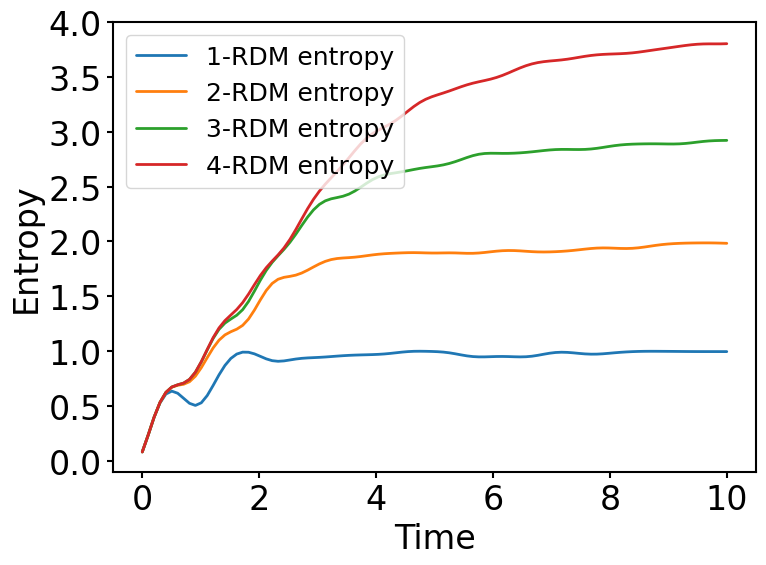

In [56]:
n = 12 
initial_state = cudaq.get_state(get_initial_state, n)
subsystem = 4 
t_list = np.linspace(0, 10, 100) 

for i in range(1, subsystem + 1):
    n_12_p, sub_12_p = simulation_typical(n, 'entropy', i, initial_state, r=100, h_x_val=0.8090, h_y_val=0.9045, J_val=1.0)
    plt.plot(t_list, n_12_p, label=f'{i}-RDM entropy')

plt.yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])  

plt.legend()
plt.xlabel('Time')
plt.ylabel('Entropy') 
plt.show()

/tmp/ipykernel_1563310/1119622745.py:4: DeprecationWarning: use `evaluate_coefficient` instead
  result.append(term.get_coefficient())


(0+0i) + (1+0i) * X0X1 + (1+0i) * X1X2 + (1+0i) * X2X3 + (1+0i) * X3X4 + (1+0i) * X4X5 + (1+0i) * X5X6 + (1+0i) * X6X7 + (1+0i) * X7X8 + (1+0i) * X8X9 + (1+0i) * X9X10 + (1+0i) * X10X11 + (1+0i) * X11X12 + (1+0i) * X12X13 + (1+0i) * X13X14 + (1+0i) * X14X15 + (1+0i) * X15X16 + (1+0i) * X16X17 + (1+0i) * X17X18 + (1+0i) * X18X19 + (0.809+0i) * X0 + (0.9045+0i) * Y0 + (0.809+0i) * X1 + (0.9045+0i) * Y1 + (0.809+0i) * X2 + (0.9045+0i) * Y2 + (0.809+0i) * X3 + (0.9045+0i) * Y3 + (0.809+0i) * X4 + (0.9045+0i) * Y4 + (0.809+0i) * X5 + (0.9045+0i) * Y5 + (0.809+0i) * X6 + (0.9045+0i) * Y6 + (0.809+0i) * X7 + (0.9045+0i) * Y7 + (0.809+0i) * X8 + (0.9045+0i) * Y8 + (0.809+0i) * X9 + (0.9045+0i) * Y9 + (0.809+0i) * X10 + (0.9045+0i) * Y10 + (0.809+0i) * X11 + (0.9045+0i) * Y11 + (0.809+0i) * X12 + (0.9045+0i) * Y12 + (0.809+0i) * X13 + (0.9045+0i) * Y13 + (0.809+0i) * X14 + (0.9045+0i) * Y14 + (0.809+0i) * X15 + (0.9045+0i) * Y15 + (0.809+0i) * X16 + (0.9045+0i) * Y16 + (0.809+0i) * X17 + (0.904

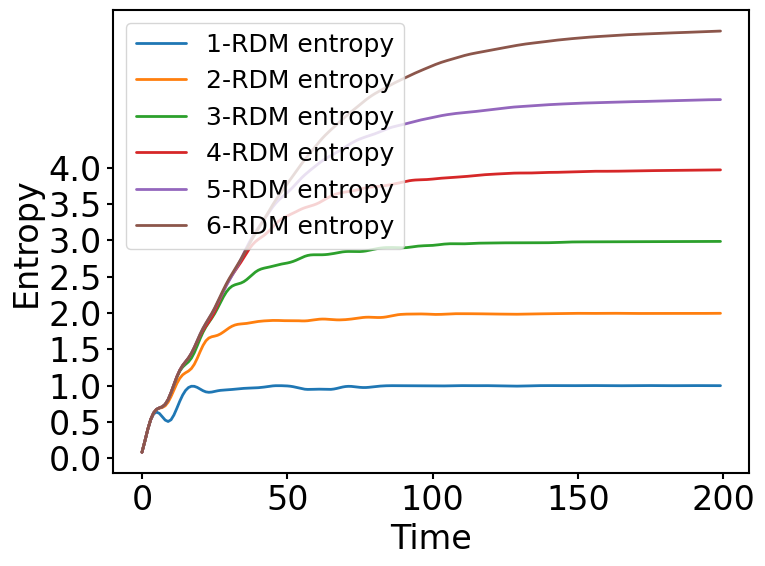

In [ ]:
n = 20
initial_state = cudaq.get_state(get_initial_state, n)
subsystem = 6
t_list = np.linspace(0, 20, 200) 
r = 200

for i in range(1, subsystem + 1):
    n_12_p, sub_12_p = simulation_typical(n, 'entropy', i, initial_state, r=r, h_x_val=0.8090, h_y_val=0.9045, J_val=1.0) 
    plt.plot(t_list, n_12_p, label=f'{i}-RDM entropy')

plt.yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])  

plt.legend()
plt.xlabel('Time')
plt.ylabel('Entropy') 
plt.show()

In [67]:
def simulation_atypical (n_spins: int, cal: str, sub: int, initial_state, r=100, h_x_val=0.8090, h_y_val=0.9045, J_val=1.0): 
    n = n_spins
    state = initial_state
    out_list = []
    time_list = []

    dt = 0.1
    subsystem = list(range(sub)) 

    h_x = np.full(n_spins, h_x_val) 
    h_y = np.full(n_spins, h_y_val) 
    h_z = np.zeros(n_spins)

    hamiltonian = create_hamiltonian_qimf(n_spins, J=J_val, h_x=h_x_val, h_y=h_y_val)
    
    coefficients = extractCoefficients(hamiltonian)
    words = extractWords(hamiltonian)
    Jy = 0 
    Jz = 0
    Jx = 1.0
    _use_XXYYZZ_gate = False
    print(hamiltonian) 
    print(coefficients) 
    
    start_time = time.time()
    for step in range(1, r + 1):
        t = step * dt
        state = cudaq.get_state(trotter_step, state, dt, Jx, Jy, Jz, h_x, h_y, h_z,
                                _use_XXYYZZ_gate, coefficients, words)
        psi = cp.array(state)
        rho_A = partial_trace_schmidt_cupy(psi, subsystem, n_qubits=n_spins)
        if cal == 'purity':
            S = purity(rho_A)
        elif cal == 'entropy':
            S = entropy(rho_A)
        else:
            print('invalid input') 
            return 1 
            
        out_list.append(S)
        time_list.append(dt * step)
    
    total_time = time.time() - start_time
    print(f"Simulation done in {total_time:.2f} seconds")
    out_np = np.array([x.get() if hasattr(x, 'get') else x for x in out_list])
    return out_np, subsystem

/tmp/ipykernel_1563310/1119622745.py:4: DeprecationWarning: use `evaluate_coefficient` instead
  result.append(term.get_coefficient())


(0+0i) + (1+0i) * X0X1 + (1+0i) * X1X2 + (1+0i) * X2X3 + (1+0i) * X3X4 + (1+0i) * X4X5 + (1+0i) * X5X6 + (1+0i) * X6X7 + (1+0i) * X7X8 + (1+0i) * X8X9 + (1+0i) * X9X10 + (1+0i) * X10X11 + (0+0i) * X0 + (0.9045+0i) * Y0 + (0+0i) * X1 + (0.9045+0i) * Y1 + (0+0i) * X2 + (0.9045+0i) * Y2 + (0+0i) * X3 + (0.9045+0i) * Y3 + (0+0i) * X4 + (0.9045+0i) * Y4 + (0+0i) * X5 + (0.9045+0i) * Y5 + (0+0i) * X6 + (0.9045+0i) * Y6 + (0+0i) * X7 + (0.9045+0i) * Y7 + (0+0i) * X8 + (0.9045+0i) * Y8 + (0+0i) * X9 + (0.9045+0i) * Y9 + (0+0i) * X10 + (0.9045+0i) * Y10 + (0+0i) * X11 + (0.9045+0i) * Y11
[0j, (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), 0j, (0.9045+0j), 0j, (0.9045+0j), 0j, (0.9045+0j), 0j, (0.9045+0j), 0j, (0.9045+0j), 0j, (0.9045+0j), 0j, (0.9045+0j), 0j, (0.9045+0j), 0j, (0.9045+0j), 0j, (0.9045+0j), 0j, (0.9045+0j), 0j, (0.9045+0j)]
Simulation done in 2.82 seconds
(0+0i) + (1+0i) * X0X1 + (1+0i) * X1X2 + (1+0i) * X2X3 + (1+0i) * X3X4 + (1+0i) * X4X

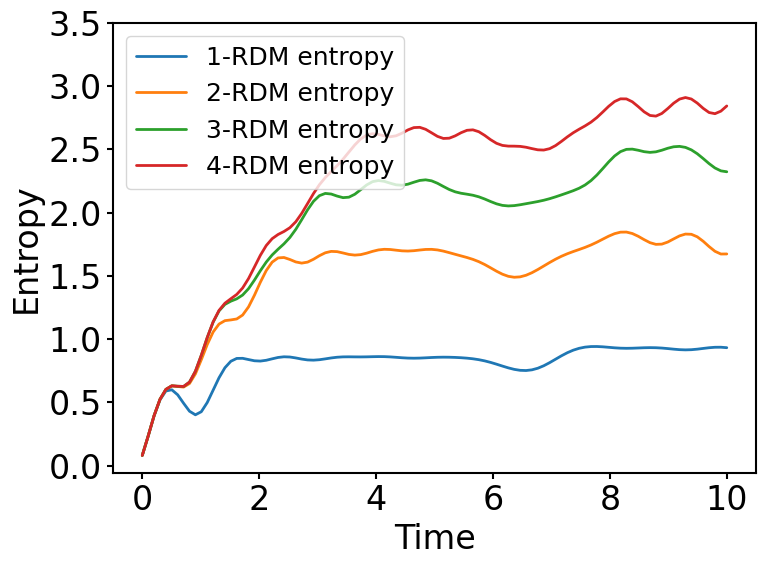

In [68]:
n = 12 
initial_state = cudaq.get_state(get_initial_state, n)
subsystem = 4
t_list = np.linspace(0, 10, 100) 

for i in range(1, subsystem + 1):
    n_12_p, sub_12_p = simulation_atypical(n, 'entropy', i, initial_state, r=100, h_x_val=0.0, h_y_val=0.9045, J_val=1.0) 
    plt.plot(t_list, n_12_p, label=f'{i}-RDM entropy')

plt.yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])  
plt.legend()
plt.xlabel('Time')
plt.ylabel('Entropy') 
plt.show()